# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [10]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [11]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [12]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 13 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=6,groups=1,dilation=1,bias=True) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=torch.randn(w[0].shape).cuda()*1
        
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        w=self.scaleLayer(w)
        if a>0.37:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
        
        if a>0.37:
            print(self.conv1D.weight.shape)
            print(self.conv1D.weight)
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [13]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [14]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [15]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [16]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [17]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [18]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.310900, Accuracy: 10.55
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.377024, Accuracy: 11.72
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.342770, Accuracy: 6.64
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.304077, Accuracy: 10.16
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.238168, Accuracy: 14.45
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.120892, Accuracy: 20.70
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.119954, Accuracy: 20.31
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.172742, Accuracy: 16.80
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.068606, Accuracy: 20.31
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.051823, Accuracy: 22.66
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.970165, Accuracy: 23.05
Train Epoch: 0 [14080/50000 (31%)]	Loss: 2.014423, Accuracy: 21.88
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.884346, Accuracy: 23.83
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.868824, Accuracy: 23.44
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.891617, Accuracy: 23.83
Train Epoch

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.163964, Accuracy: 56.25
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.159840, Accuracy: 59.38
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.164303, Accuracy: 59.77
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.128883, Accuracy: 60.94
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.148498, Accuracy: 59.38
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.123016, Accuracy: 60.55
Train Epoch: 3 [21760/50000 (48%)]	Loss: 0.978111, Accuracy: 58.98
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.115419, Accuracy: 57.81
Train Epoch: 3 [24320/50000 (54%)]	Loss: 0.957566, Accuracy: 67.19
Train Epoch: 3 [25600/50000 (57%)]	Loss: 1.113405, Accuracy: 60.55
Train Epoch: 3 [26880/50000 (60%)]	Loss: 1.047447, Accuracy: 59.77
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.083948, Accuracy: 60.16
Train Epoch: 3 [29440/50000 (65%)]	Loss: 1.084501, Accuracy: 60.94
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.064592, Accuracy: 62.11
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.047152, Accuracy: 6

Train Epoch: 4 [17920/50000 (40%)]	Loss: 0.883320, Accuracy: 67.58
Train Epoch: 4 [19200/50000 (43%)]	Loss: 0.962432, Accuracy: 67.58
Train Epoch: 4 [20480/50000 (45%)]	Loss: 0.939759, Accuracy: 64.84
Train Epoch: 4 [21760/50000 (48%)]	Loss: 1.012491, Accuracy: 62.11
Train Epoch: 4 [23040/50000 (51%)]	Loss: 0.887016, Accuracy: 71.09
Train Epoch: 4 [24320/50000 (54%)]	Loss: 0.954931, Accuracy: 67.19
Train Epoch: 4 [25600/50000 (57%)]	Loss: 0.837436, Accuracy: 70.70
Train Epoch: 4 [26880/50000 (60%)]	Loss: 0.903321, Accuracy: 66.02
Train Epoch: 4 [28160/50000 (62%)]	Loss: 0.993783, Accuracy: 63.67
Train Epoch: 4 [29440/50000 (65%)]	Loss: 0.903765, Accuracy: 65.62
Train Epoch: 4 [30720/50000 (68%)]	Loss: 0.919539, Accuracy: 65.62
Train Epoch: 4 [32000/50000 (71%)]	Loss: 0.878735, Accuracy: 67.58
Train Epoch: 4 [33280/50000 (74%)]	Loss: 0.949895, Accuracy: 63.67
Train Epoch: 4 [34560/50000 (77%)]	Loss: 0.868224, Accuracy: 67.97
Train Epoch: 4 [35840/50000 (80%)]	Loss: 1.011438, Accuracy: 6

Train Epoch: 7 [30720/50000 (68%)]	Loss: 0.639015, Accuracy: 76.95
Train Epoch: 7 [32000/50000 (71%)]	Loss: 0.677657, Accuracy: 76.17
Train Epoch: 7 [33280/50000 (74%)]	Loss: 0.569188, Accuracy: 81.64
Train Epoch: 7 [34560/50000 (77%)]	Loss: 0.553536, Accuracy: 82.81
Train Epoch: 7 [35840/50000 (80%)]	Loss: 0.706970, Accuracy: 77.34
Train Epoch: 7 [37120/50000 (82%)]	Loss: 0.696520, Accuracy: 75.78
Train Epoch: 7 [38400/50000 (85%)]	Loss: 0.803331, Accuracy: 71.48
Train Epoch: 7 [39680/50000 (88%)]	Loss: 0.653795, Accuracy: 76.95
Train Epoch: 7 [40960/50000 (91%)]	Loss: 0.721933, Accuracy: 73.05
Train Epoch: 7 [42240/50000 (94%)]	Loss: 0.660897, Accuracy: 76.95
Train Epoch: 7 [43520/50000 (97%)]	Loss: 0.741886, Accuracy: 76.17
Train Epoch: 7 [35000/50000 (99%)]	Loss: 0.722037, Accuracy: 74.50

Validation set: Average loss: 1.4089, Accuracy: 2779/5000 (55.00%)

the time of this epoch:[36.5019428730011 s]
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.575518, Accuracy: 82.03
Train Epoch: 8 [1280/

Train Epoch: 8 [42240/50000 (94%)]	Loss: 0.547898, Accuracy: 81.25
Train Epoch: 8 [43520/50000 (97%)]	Loss: 0.619870, Accuracy: 77.34
Train Epoch: 8 [35000/50000 (99%)]	Loss: 0.675455, Accuracy: 79.00

Validation set: Average loss: 0.6958, Accuracy: 3786/5000 (75.00%)

the time of this epoch:[36.54272413253784 s]
Train Epoch: 9 [0/50000 (0%)]	Loss: 0.531935, Accuracy: 83.98
Train Epoch: 9 [1280/50000 (3%)]	Loss: 0.618826, Accuracy: 77.34
Train Epoch: 9 [2560/50000 (6%)]	Loss: 0.601243, Accuracy: 78.52
Train Epoch: 9 [3840/50000 (9%)]	Loss: 0.629306, Accuracy: 80.08
Train Epoch: 9 [5120/50000 (11%)]	Loss: 0.582955, Accuracy: 80.86
Train Epoch: 9 [6400/50000 (14%)]	Loss: 0.597590, Accuracy: 78.52
Train Epoch: 9 [7680/50000 (17%)]	Loss: 0.557599, Accuracy: 80.86
Train Epoch: 9 [8960/50000 (20%)]	Loss: 0.620252, Accuracy: 78.52
Train Epoch: 9 [10240/50000 (23%)]	Loss: 0.590183, Accuracy: 81.64
Train Epoch: 9 [11520/50000 (26%)]	Loss: 0.600226, Accuracy: 78.12
Train Epoch: 9 [12800/50000 (2

Train Epoch: 9 [21760/50000 (48%)]	Loss: 0.586371, Accuracy: 81.64
Train Epoch: 9 [23040/50000 (51%)]	Loss: 0.669941, Accuracy: 77.73
Train Epoch: 9 [24320/50000 (54%)]	Loss: 0.525115, Accuracy: 82.81
Train Epoch: 9 [25600/50000 (57%)]	Loss: 0.543337, Accuracy: 80.08
Train Epoch: 9 [26880/50000 (60%)]	Loss: 0.523830, Accuracy: 81.64
Train Epoch: 9 [28160/50000 (62%)]	Loss: 0.663104, Accuracy: 78.52
Train Epoch: 9 [29440/50000 (65%)]	Loss: 0.607716, Accuracy: 80.47
Train Epoch: 9 [30720/50000 (68%)]	Loss: 0.578304, Accuracy: 81.25
Train Epoch: 9 [32000/50000 (71%)]	Loss: 0.576207, Accuracy: 80.86
Train Epoch: 9 [33280/50000 (74%)]	Loss: 0.671957, Accuracy: 78.91
Train Epoch: 9 [34560/50000 (77%)]	Loss: 0.669817, Accuracy: 78.91
Train Epoch: 9 [35840/50000 (80%)]	Loss: 0.515632, Accuracy: 84.77
Train Epoch: 9 [37120/50000 (82%)]	Loss: 0.581581, Accuracy: 79.30
Train Epoch: 9 [38400/50000 (85%)]	Loss: 0.511427, Accuracy: 82.42
Train Epoch: 9 [39680/50000 (88%)]	Loss: 0.554914, Accuracy: 8

Train Epoch: 12 [32000/50000 (71%)]	Loss: 0.559628, Accuracy: 83.20
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.574699, Accuracy: 79.30
Train Epoch: 12 [34560/50000 (77%)]	Loss: 0.466497, Accuracy: 84.77
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.526085, Accuracy: 81.64
Train Epoch: 12 [37120/50000 (82%)]	Loss: 0.504718, Accuracy: 82.81
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.580093, Accuracy: 79.69
Train Epoch: 12 [39680/50000 (88%)]	Loss: 0.585701, Accuracy: 79.30
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.512196, Accuracy: 81.25
Train Epoch: 12 [42240/50000 (94%)]	Loss: 0.573764, Accuracy: 80.47
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.451273, Accuracy: 85.16
Train Epoch: 12 [35000/50000 (99%)]	Loss: 0.589612, Accuracy: 80.50

Validation set: Average loss: 0.7578, Accuracy: 3800/5000 (76.00%)

the time of this epoch:[36.57694673538208 s]

Test set: Average loss: 0.7859, Accuracy: 7497/10000 (74.97%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.465281, Accuracy: 83.59
Train Epoch

Train Epoch: 15 [40960/50000 (91%)]	Loss: 0.457262, Accuracy: 83.98
Train Epoch: 15 [42240/50000 (94%)]	Loss: 0.531166, Accuracy: 82.81
Train Epoch: 15 [43520/50000 (97%)]	Loss: 0.469614, Accuracy: 86.72
Train Epoch: 15 [35000/50000 (99%)]	Loss: 0.432854, Accuracy: 86.00

Validation set: Average loss: 0.6653, Accuracy: 3889/5000 (77.00%)

the time of this epoch:[39.519659757614136 s]
Train Epoch: 16 [0/50000 (0%)]	Loss: 0.498297, Accuracy: 82.42
Train Epoch: 16 [1280/50000 (3%)]	Loss: 0.446252, Accuracy: 84.77
Train Epoch: 16 [2560/50000 (6%)]	Loss: 0.399584, Accuracy: 87.11
Train Epoch: 16 [3840/50000 (9%)]	Loss: 0.436900, Accuracy: 85.94
Train Epoch: 16 [5120/50000 (11%)]	Loss: 0.464420, Accuracy: 85.55
Train Epoch: 16 [6400/50000 (14%)]	Loss: 0.409935, Accuracy: 84.38
Train Epoch: 16 [7680/50000 (17%)]	Loss: 0.421638, Accuracy: 84.77
Train Epoch: 16 [8960/50000 (20%)]	Loss: 0.473496, Accuracy: 85.16
Train Epoch: 16 [10240/50000 (23%)]	Loss: 0.527816, Accuracy: 81.25
Train Epoch: 16 

Train Epoch: 19 [1280/50000 (3%)]	Loss: 0.303516, Accuracy: 88.67
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.404800, Accuracy: 86.33
Train Epoch: 19 [3840/50000 (9%)]	Loss: 0.481455, Accuracy: 83.59
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.366714, Accuracy: 85.16
Train Epoch: 19 [6400/50000 (14%)]	Loss: 0.480183, Accuracy: 85.16
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.572997, Accuracy: 79.30
Train Epoch: 19 [8960/50000 (20%)]	Loss: 0.388126, Accuracy: 87.50
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.377992, Accuracy: 85.55
Train Epoch: 19 [11520/50000 (26%)]	Loss: 0.372192, Accuracy: 85.94
Train Epoch: 19 [12800/50000 (28%)]	Loss: 0.497197, Accuracy: 83.98
Train Epoch: 19 [14080/50000 (31%)]	Loss: 0.435955, Accuracy: 82.03
Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.488135, Accuracy: 81.64
Train Epoch: 19 [16640/50000 (37%)]	Loss: 0.435938, Accuracy: 83.98
Train Epoch: 19 [17920/50000 (40%)]	Loss: 0.462483, Accuracy: 82.81
Train Epoch: 19 [19200/50000 (43%)]	Loss: 0.392035, Accura

Train Epoch: 21 [28160/50000 (62%)]	Loss: 0.506725, Accuracy: 84.38
Train Epoch: 21 [29440/50000 (65%)]	Loss: 0.414388, Accuracy: 85.55
Train Epoch: 21 [30720/50000 (68%)]	Loss: 0.442187, Accuracy: 85.94
Train Epoch: 21 [32000/50000 (71%)]	Loss: 0.495765, Accuracy: 82.81
Train Epoch: 21 [33280/50000 (74%)]	Loss: 0.425978, Accuracy: 84.38
Train Epoch: 21 [34560/50000 (77%)]	Loss: 0.448069, Accuracy: 84.38
Train Epoch: 21 [35840/50000 (80%)]	Loss: 0.507638, Accuracy: 83.59
Train Epoch: 21 [37120/50000 (82%)]	Loss: 0.417597, Accuracy: 88.28
Train Epoch: 21 [38400/50000 (85%)]	Loss: 0.503662, Accuracy: 83.20
Train Epoch: 21 [39680/50000 (88%)]	Loss: 0.403867, Accuracy: 85.94
Train Epoch: 21 [40960/50000 (91%)]	Loss: 0.383837, Accuracy: 85.94
Train Epoch: 21 [42240/50000 (94%)]	Loss: 0.395437, Accuracy: 86.72
Train Epoch: 21 [43520/50000 (97%)]	Loss: 0.593142, Accuracy: 80.08
Train Epoch: 21 [35000/50000 (99%)]	Loss: 0.358544, Accuracy: 88.00

Validation set: Average loss: 0.6782, Accuracy:

Train Epoch: 24 [38400/50000 (85%)]	Loss: 0.377491, Accuracy: 87.89
Train Epoch: 24 [39680/50000 (88%)]	Loss: 0.442127, Accuracy: 82.81
Train Epoch: 24 [40960/50000 (91%)]	Loss: 0.429015, Accuracy: 84.38
Train Epoch: 24 [42240/50000 (94%)]	Loss: 0.441521, Accuracy: 85.16
Train Epoch: 24 [43520/50000 (97%)]	Loss: 0.402316, Accuracy: 87.50
Train Epoch: 24 [35000/50000 (99%)]	Loss: 0.355971, Accuracy: 88.00

Validation set: Average loss: 0.5473, Accuracy: 4108/5000 (82.00%)

the time of this epoch:[36.425700187683105 s]

Test set: Average loss: 0.5595, Accuracy: 8174/10000 (81.74%)

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.404050, Accuracy: 87.11
Train Epoch: 25 [1280/50000 (3%)]	Loss: 0.354028, Accuracy: 89.45
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.346664, Accuracy: 90.23
Train Epoch: 25 [3840/50000 (9%)]	Loss: 0.392730, Accuracy: 86.33
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.344696, Accuracy: 88.28
Train Epoch: 25 [6400/50000 (14%)]	Loss: 0.396877, Accuracy: 86.33
Train Epoch: 25 [7

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.334823, Accuracy: 89.84
Train Epoch: 28 [1280/50000 (3%)]	Loss: 0.392459, Accuracy: 88.28
Train Epoch: 28 [2560/50000 (6%)]	Loss: 0.441794, Accuracy: 83.98
Train Epoch: 28 [3840/50000 (9%)]	Loss: 0.377665, Accuracy: 85.55
Train Epoch: 28 [5120/50000 (11%)]	Loss: 0.332661, Accuracy: 89.45
Train Epoch: 28 [6400/50000 (14%)]	Loss: 0.340773, Accuracy: 88.67
Train Epoch: 28 [7680/50000 (17%)]	Loss: 0.370730, Accuracy: 85.55
Train Epoch: 28 [8960/50000 (20%)]	Loss: 0.337146, Accuracy: 89.06
Train Epoch: 28 [10240/50000 (23%)]	Loss: 0.380154, Accuracy: 85.94
Train Epoch: 28 [11520/50000 (26%)]	Loss: 0.405733, Accuracy: 87.11
Train Epoch: 28 [12800/50000 (28%)]	Loss: 0.444609, Accuracy: 85.16
Train Epoch: 28 [14080/50000 (31%)]	Loss: 0.432747, Accuracy: 85.55
Train Epoch: 28 [15360/50000 (34%)]	Loss: 0.344555, Accuracy: 88.28
Train Epoch: 28 [16640/50000 (37%)]	Loss: 0.349964, Accuracy: 87.50
Train Epoch: 28 [17920/50000 (40%)]	Loss: 0.280632, Accuracy: 9

Train Epoch: 31 [8960/50000 (20%)]	Loss: 0.456091, Accuracy: 84.38
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.381817, Accuracy: 87.11
Train Epoch: 31 [11520/50000 (26%)]	Loss: 0.431832, Accuracy: 85.16
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.368304, Accuracy: 89.45
Train Epoch: 31 [14080/50000 (31%)]	Loss: 0.489602, Accuracy: 83.20
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.405825, Accuracy: 85.94
Train Epoch: 31 [16640/50000 (37%)]	Loss: 0.342292, Accuracy: 86.72
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.397902, Accuracy: 86.72
Train Epoch: 31 [19200/50000 (43%)]	Loss: 0.337789, Accuracy: 89.06
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.454677, Accuracy: 83.20
Train Epoch: 31 [21760/50000 (48%)]	Loss: 0.282119, Accuracy: 91.02
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.296477, Accuracy: 89.06
Train Epoch: 31 [24320/50000 (54%)]	Loss: 0.502219, Accuracy: 80.86
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.481564, Accuracy: 82.42
Train Epoch: 31 [26880/50000 (60%)]	Loss: 0.43580

Train Epoch: 33 [14080/50000 (31%)]	Loss: 0.449456, Accuracy: 84.38
Train Epoch: 33 [15360/50000 (34%)]	Loss: 0.366138, Accuracy: 87.50
Train Epoch: 33 [16640/50000 (37%)]	Loss: 0.405760, Accuracy: 84.38
Train Epoch: 33 [17920/50000 (40%)]	Loss: 0.552573, Accuracy: 80.86
Train Epoch: 33 [19200/50000 (43%)]	Loss: 0.482858, Accuracy: 85.16
Train Epoch: 33 [20480/50000 (45%)]	Loss: 0.483496, Accuracy: 84.77
Train Epoch: 33 [21760/50000 (48%)]	Loss: 0.367880, Accuracy: 87.89
Train Epoch: 33 [23040/50000 (51%)]	Loss: 0.469100, Accuracy: 84.38
Train Epoch: 33 [24320/50000 (54%)]	Loss: 0.383574, Accuracy: 85.94
Train Epoch: 33 [25600/50000 (57%)]	Loss: 0.276581, Accuracy: 91.41
Train Epoch: 33 [26880/50000 (60%)]	Loss: 0.444129, Accuracy: 85.16
Train Epoch: 33 [28160/50000 (62%)]	Loss: 0.275956, Accuracy: 90.62
Train Epoch: 33 [29440/50000 (65%)]	Loss: 0.417237, Accuracy: 88.67
Train Epoch: 33 [30720/50000 (68%)]	Loss: 0.516331, Accuracy: 81.25
Train Epoch: 33 [32000/50000 (71%)]	Loss: 0.3862

Train Epoch: 36 [24320/50000 (54%)]	Loss: 0.358888, Accuracy: 85.16
Train Epoch: 36 [25600/50000 (57%)]	Loss: 0.316192, Accuracy: 89.45
Train Epoch: 36 [26880/50000 (60%)]	Loss: 0.388665, Accuracy: 87.50
Train Epoch: 36 [28160/50000 (62%)]	Loss: 0.409102, Accuracy: 87.11
Train Epoch: 36 [29440/50000 (65%)]	Loss: 0.348941, Accuracy: 87.50
Train Epoch: 36 [30720/50000 (68%)]	Loss: 0.388118, Accuracy: 85.94
Train Epoch: 36 [32000/50000 (71%)]	Loss: 0.381455, Accuracy: 85.55
Train Epoch: 36 [33280/50000 (74%)]	Loss: 0.409503, Accuracy: 84.77
Train Epoch: 36 [34560/50000 (77%)]	Loss: 0.443904, Accuracy: 86.72
Train Epoch: 36 [35840/50000 (80%)]	Loss: 0.371955, Accuracy: 86.72
Train Epoch: 36 [37120/50000 (82%)]	Loss: 0.394165, Accuracy: 87.50
Train Epoch: 36 [38400/50000 (85%)]	Loss: 0.408001, Accuracy: 85.94
Train Epoch: 36 [39680/50000 (88%)]	Loss: 0.507856, Accuracy: 80.08
Train Epoch: 36 [40960/50000 (91%)]	Loss: 0.483972, Accuracy: 82.42
Train Epoch: 36 [42240/50000 (94%)]	Loss: 0.4231

Train Epoch: 39 [33280/50000 (74%)]	Loss: 0.336927, Accuracy: 88.67
Train Epoch: 39 [34560/50000 (77%)]	Loss: 0.348759, Accuracy: 87.89
Train Epoch: 39 [35840/50000 (80%)]	Loss: 0.323871, Accuracy: 88.28
Train Epoch: 39 [37120/50000 (82%)]	Loss: 0.319662, Accuracy: 87.89
Train Epoch: 39 [38400/50000 (85%)]	Loss: 0.493438, Accuracy: 83.98
Train Epoch: 39 [39680/50000 (88%)]	Loss: 0.424155, Accuracy: 86.33
Train Epoch: 39 [40960/50000 (91%)]	Loss: 0.376007, Accuracy: 87.89
Train Epoch: 39 [42240/50000 (94%)]	Loss: 0.268446, Accuracy: 91.02
Train Epoch: 39 [43520/50000 (97%)]	Loss: 0.326964, Accuracy: 88.67
Train Epoch: 39 [35000/50000 (99%)]	Loss: 0.432811, Accuracy: 88.00

Validation set: Average loss: 0.6260, Accuracy: 3986/5000 (79.00%)

the time of this epoch:[39.43285012245178 s]
Train Epoch: 40 [0/50000 (0%)]	Loss: 0.306331, Accuracy: 87.11
Train Epoch: 40 [1280/50000 (3%)]	Loss: 0.337611, Accuracy: 87.50
Train Epoch: 40 [2560/50000 (6%)]	Loss: 0.388340, Accuracy: 85.55
Train Epoch

Train Epoch: 42 [43520/50000 (97%)]	Loss: 0.384873, Accuracy: 87.50
Train Epoch: 42 [35000/50000 (99%)]	Loss: 0.359269, Accuracy: 86.50

Validation set: Average loss: 0.6499, Accuracy: 3932/5000 (78.00%)

the time of this epoch:[36.333221673965454 s]

Test set: Average loss: 0.6656, Accuracy: 7847/10000 (78.47%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.375959, Accuracy: 87.50
Train Epoch: 43 [1280/50000 (3%)]	Loss: 0.276516, Accuracy: 91.41
Train Epoch: 43 [2560/50000 (6%)]	Loss: 0.300378, Accuracy: 89.84
Train Epoch: 43 [3840/50000 (9%)]	Loss: 0.305303, Accuracy: 88.67
Train Epoch: 43 [5120/50000 (11%)]	Loss: 0.385824, Accuracy: 84.77
Train Epoch: 43 [6400/50000 (14%)]	Loss: 0.253335, Accuracy: 91.80
Train Epoch: 43 [7680/50000 (17%)]	Loss: 0.349547, Accuracy: 87.50
Train Epoch: 43 [8960/50000 (20%)]	Loss: 0.349754, Accuracy: 86.72
Train Epoch: 43 [10240/50000 (23%)]	Loss: 0.403730, Accuracy: 88.28
Train Epoch: 43 [11520/50000 (26%)]	Loss: 0.350306, Accuracy: 89.84
Train Epoch: 43 [128

Train Epoch: 43 [30720/50000 (68%)]	Loss: 0.326146, Accuracy: 89.45
Train Epoch: 43 [32000/50000 (71%)]	Loss: 0.322451, Accuracy: 89.06
Train Epoch: 43 [33280/50000 (74%)]	Loss: 0.362874, Accuracy: 87.50
Train Epoch: 43 [34560/50000 (77%)]	Loss: 0.392246, Accuracy: 86.72
Train Epoch: 43 [35840/50000 (80%)]	Loss: 0.372240, Accuracy: 87.89
Train Epoch: 43 [37120/50000 (82%)]	Loss: 0.276837, Accuracy: 89.84
Train Epoch: 43 [38400/50000 (85%)]	Loss: 0.431726, Accuracy: 83.98
Train Epoch: 43 [39680/50000 (88%)]	Loss: 0.383415, Accuracy: 87.11
Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.337995, Accuracy: 88.67
Train Epoch: 43 [42240/50000 (94%)]	Loss: 0.415402, Accuracy: 85.16
Train Epoch: 43 [43520/50000 (97%)]	Loss: 0.409236, Accuracy: 84.38
Train Epoch: 43 [35000/50000 (99%)]	Loss: 0.339342, Accuracy: 89.00

Validation set: Average loss: 0.5087, Accuracy: 4161/5000 (83.00%)

the time of this epoch:[39.50084948539734 s]
Train Epoch: 44 [0/50000 (0%)]	Loss: 0.283574, Accuracy: 91.02
Train E

Train Epoch: 46 [8960/50000 (20%)]	Loss: 0.337003, Accuracy: 89.84
Train Epoch: 46 [10240/50000 (23%)]	Loss: 0.418447, Accuracy: 87.11
Train Epoch: 46 [11520/50000 (26%)]	Loss: 0.392455, Accuracy: 86.33
Train Epoch: 46 [12800/50000 (28%)]	Loss: 0.362729, Accuracy: 89.45
Train Epoch: 46 [14080/50000 (31%)]	Loss: 0.396994, Accuracy: 85.16
Train Epoch: 46 [15360/50000 (34%)]	Loss: 0.302520, Accuracy: 88.28
Train Epoch: 46 [16640/50000 (37%)]	Loss: 0.298301, Accuracy: 88.67
Train Epoch: 46 [17920/50000 (40%)]	Loss: 0.383832, Accuracy: 88.28
Train Epoch: 46 [19200/50000 (43%)]	Loss: 0.356554, Accuracy: 85.55
Train Epoch: 46 [20480/50000 (45%)]	Loss: 0.377429, Accuracy: 85.16
Train Epoch: 46 [21760/50000 (48%)]	Loss: 0.341904, Accuracy: 89.06
Train Epoch: 46 [23040/50000 (51%)]	Loss: 0.409942, Accuracy: 87.50
Train Epoch: 46 [24320/50000 (54%)]	Loss: 0.358303, Accuracy: 89.06
Train Epoch: 46 [25600/50000 (57%)]	Loss: 0.484423, Accuracy: 80.47
Train Epoch: 46 [26880/50000 (60%)]	Loss: 0.42012

Train Epoch: 49 [17920/50000 (40%)]	Loss: 0.373125, Accuracy: 86.72
Train Epoch: 49 [19200/50000 (43%)]	Loss: 0.287595, Accuracy: 90.23
Train Epoch: 49 [20480/50000 (45%)]	Loss: 0.368193, Accuracy: 87.89
Train Epoch: 49 [21760/50000 (48%)]	Loss: 0.283674, Accuracy: 89.45
Train Epoch: 49 [23040/50000 (51%)]	Loss: 0.409757, Accuracy: 86.72
Train Epoch: 49 [24320/50000 (54%)]	Loss: 0.320184, Accuracy: 90.62
Train Epoch: 49 [25600/50000 (57%)]	Loss: 0.456032, Accuracy: 85.55
Train Epoch: 49 [26880/50000 (60%)]	Loss: 0.325609, Accuracy: 89.45
Train Epoch: 49 [28160/50000 (62%)]	Loss: 0.431726, Accuracy: 86.33
Train Epoch: 49 [29440/50000 (65%)]	Loss: 0.414544, Accuracy: 84.38
Train Epoch: 49 [30720/50000 (68%)]	Loss: 0.434764, Accuracy: 84.77
Train Epoch: 49 [32000/50000 (71%)]	Loss: 0.335162, Accuracy: 88.28
Train Epoch: 49 [33280/50000 (74%)]	Loss: 0.500769, Accuracy: 85.55
Train Epoch: 49 [34560/50000 (77%)]	Loss: 0.392891, Accuracy: 86.33
Train Epoch: 49 [35840/50000 (80%)]	Loss: 0.3007

Train Epoch: 52 [28160/50000 (62%)]	Loss: 0.148689, Accuracy: 95.31
Train Epoch: 52 [29440/50000 (65%)]	Loss: 0.149352, Accuracy: 95.70
Train Epoch: 52 [30720/50000 (68%)]	Loss: 0.177288, Accuracy: 93.75
Train Epoch: 52 [32000/50000 (71%)]	Loss: 0.154380, Accuracy: 95.31
Train Epoch: 52 [33280/50000 (74%)]	Loss: 0.152414, Accuracy: 93.36
Train Epoch: 52 [34560/50000 (77%)]	Loss: 0.201453, Accuracy: 93.36
Train Epoch: 52 [35840/50000 (80%)]	Loss: 0.158774, Accuracy: 93.75
Train Epoch: 52 [37120/50000 (82%)]	Loss: 0.233230, Accuracy: 92.19
Train Epoch: 52 [38400/50000 (85%)]	Loss: 0.261551, Accuracy: 90.23
Train Epoch: 52 [39680/50000 (88%)]	Loss: 0.167610, Accuracy: 93.75
Train Epoch: 52 [40960/50000 (91%)]	Loss: 0.126188, Accuracy: 96.48
Train Epoch: 52 [42240/50000 (94%)]	Loss: 0.236609, Accuracy: 90.23
Train Epoch: 52 [43520/50000 (97%)]	Loss: 0.173595, Accuracy: 93.75
Train Epoch: 52 [35000/50000 (99%)]	Loss: 0.197805, Accuracy: 95.00

Validation set: Average loss: 0.2735, Accuracy:

Train Epoch: 55 [37120/50000 (82%)]	Loss: 0.182856, Accuracy: 94.92
Train Epoch: 55 [38400/50000 (85%)]	Loss: 0.158243, Accuracy: 94.14
Train Epoch: 55 [39680/50000 (88%)]	Loss: 0.118338, Accuracy: 95.70
Train Epoch: 55 [40960/50000 (91%)]	Loss: 0.103431, Accuracy: 96.88
Train Epoch: 55 [42240/50000 (94%)]	Loss: 0.169642, Accuracy: 94.92
Train Epoch: 55 [43520/50000 (97%)]	Loss: 0.094659, Accuracy: 96.09
Train Epoch: 55 [35000/50000 (99%)]	Loss: 0.165495, Accuracy: 96.00

Validation set: Average loss: 0.2748, Accuracy: 4559/5000 (91.00%)

the time of this epoch:[39.4622004032135 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.144905, Accuracy: 94.14
Train Epoch: 56 [1280/50000 (3%)]	Loss: 0.147496, Accuracy: 93.75
Train Epoch: 56 [2560/50000 (6%)]	Loss: 0.180216, Accuracy: 92.58
Train Epoch: 56 [3840/50000 (9%)]	Loss: 0.162246, Accuracy: 95.31
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.089177, Accuracy: 96.88
Train Epoch: 56 [6400/50000 (14%)]	Loss: 0.097014, Accuracy: 96.09
Train Epoch: 56 

Train Epoch: 56 [35840/50000 (80%)]	Loss: 0.135170, Accuracy: 94.53
Train Epoch: 56 [37120/50000 (82%)]	Loss: 0.095254, Accuracy: 97.66
Train Epoch: 56 [38400/50000 (85%)]	Loss: 0.158042, Accuracy: 94.14
Train Epoch: 56 [39680/50000 (88%)]	Loss: 0.124289, Accuracy: 96.48
Train Epoch: 56 [40960/50000 (91%)]	Loss: 0.176328, Accuracy: 94.53
Train Epoch: 56 [42240/50000 (94%)]	Loss: 0.122854, Accuracy: 94.92
Train Epoch: 56 [43520/50000 (97%)]	Loss: 0.087762, Accuracy: 96.88
Train Epoch: 56 [35000/50000 (99%)]	Loss: 0.184509, Accuracy: 94.50

Validation set: Average loss: 0.2714, Accuracy: 4558/5000 (91.00%)

the time of this epoch:[36.419878244400024 s]

Test set: Average loss: 0.2860, Accuracy: 9122/10000 (91.22%)

Train Epoch: 57 [0/50000 (0%)]	Loss: 0.132418, Accuracy: 95.70
Train Epoch: 57 [1280/50000 (3%)]	Loss: 0.111636, Accuracy: 96.88
Train Epoch: 57 [2560/50000 (6%)]	Loss: 0.124809, Accuracy: 96.09
Train Epoch: 57 [3840/50000 (9%)]	Loss: 0.131699, Accuracy: 94.53
Train Epoch: 57 

Train Epoch: 59 [35000/50000 (99%)]	Loss: 0.081096, Accuracy: 98.50

Validation set: Average loss: 0.2872, Accuracy: 4560/5000 (91.00%)

the time of this epoch:[39.4444146156311 s]
Train Epoch: 60 [0/50000 (0%)]	Loss: 0.133842, Accuracy: 95.70
Train Epoch: 60 [1280/50000 (3%)]	Loss: 0.062287, Accuracy: 98.44
Train Epoch: 60 [2560/50000 (6%)]	Loss: 0.077883, Accuracy: 97.27
Train Epoch: 60 [3840/50000 (9%)]	Loss: 0.092335, Accuracy: 97.66
Train Epoch: 60 [5120/50000 (11%)]	Loss: 0.116334, Accuracy: 95.31
Train Epoch: 60 [6400/50000 (14%)]	Loss: 0.112788, Accuracy: 95.70
Train Epoch: 60 [7680/50000 (17%)]	Loss: 0.106642, Accuracy: 96.88
Train Epoch: 60 [8960/50000 (20%)]	Loss: 0.067465, Accuracy: 98.05
Train Epoch: 60 [10240/50000 (23%)]	Loss: 0.137618, Accuracy: 95.70
Train Epoch: 60 [11520/50000 (26%)]	Loss: 0.085368, Accuracy: 97.66
Train Epoch: 60 [12800/50000 (28%)]	Loss: 0.078788, Accuracy: 96.88
Train Epoch: 60 [14080/50000 (31%)]	Loss: 0.145988, Accuracy: 95.70
Train Epoch: 60 [1

Train Epoch: 63 [5120/50000 (11%)]	Loss: 0.085273, Accuracy: 97.66
Train Epoch: 63 [6400/50000 (14%)]	Loss: 0.071794, Accuracy: 97.66
Train Epoch: 63 [7680/50000 (17%)]	Loss: 0.141761, Accuracy: 94.92
Train Epoch: 63 [8960/50000 (20%)]	Loss: 0.110244, Accuracy: 96.88
Train Epoch: 63 [10240/50000 (23%)]	Loss: 0.077753, Accuracy: 96.48
Train Epoch: 63 [11520/50000 (26%)]	Loss: 0.058224, Accuracy: 98.83
Train Epoch: 63 [12800/50000 (28%)]	Loss: 0.120865, Accuracy: 96.09
Train Epoch: 63 [14080/50000 (31%)]	Loss: 0.147077, Accuracy: 94.53
Train Epoch: 63 [15360/50000 (34%)]	Loss: 0.079106, Accuracy: 97.27
Train Epoch: 63 [16640/50000 (37%)]	Loss: 0.080920, Accuracy: 97.27
Train Epoch: 63 [17920/50000 (40%)]	Loss: 0.102893, Accuracy: 96.48
Train Epoch: 63 [19200/50000 (43%)]	Loss: 0.075793, Accuracy: 97.66
Train Epoch: 63 [20480/50000 (45%)]	Loss: 0.067543, Accuracy: 98.44
Train Epoch: 63 [21760/50000 (48%)]	Loss: 0.065837, Accuracy: 98.05
Train Epoch: 63 [23040/50000 (51%)]	Loss: 0.079203, 

Train Epoch: 66 [15360/50000 (34%)]	Loss: 0.080492, Accuracy: 98.05
Train Epoch: 66 [16640/50000 (37%)]	Loss: 0.076735, Accuracy: 96.09
Train Epoch: 66 [17920/50000 (40%)]	Loss: 0.076251, Accuracy: 97.27
Train Epoch: 66 [19200/50000 (43%)]	Loss: 0.053076, Accuracy: 98.05
Train Epoch: 66 [20480/50000 (45%)]	Loss: 0.089640, Accuracy: 96.48
Train Epoch: 66 [21760/50000 (48%)]	Loss: 0.053051, Accuracy: 97.66
Train Epoch: 66 [23040/50000 (51%)]	Loss: 0.098058, Accuracy: 96.48
Train Epoch: 66 [24320/50000 (54%)]	Loss: 0.106651, Accuracy: 96.48
Train Epoch: 66 [25600/50000 (57%)]	Loss: 0.057839, Accuracy: 98.05
Train Epoch: 66 [26880/50000 (60%)]	Loss: 0.085727, Accuracy: 97.27
Train Epoch: 66 [28160/50000 (62%)]	Loss: 0.102253, Accuracy: 97.66
Train Epoch: 66 [29440/50000 (65%)]	Loss: 0.097777, Accuracy: 96.88
Train Epoch: 66 [30720/50000 (68%)]	Loss: 0.059367, Accuracy: 97.66
Train Epoch: 66 [32000/50000 (71%)]	Loss: 0.082005, Accuracy: 97.27
Train Epoch: 66 [33280/50000 (74%)]	Loss: 0.0890

Train Epoch: 69 [24320/50000 (54%)]	Loss: 0.099935, Accuracy: 96.48
Train Epoch: 69 [25600/50000 (57%)]	Loss: 0.072100, Accuracy: 97.66
Train Epoch: 69 [26880/50000 (60%)]	Loss: 0.058124, Accuracy: 98.05
Train Epoch: 69 [28160/50000 (62%)]	Loss: 0.085906, Accuracy: 96.48
Train Epoch: 69 [29440/50000 (65%)]	Loss: 0.106157, Accuracy: 95.70
Train Epoch: 69 [30720/50000 (68%)]	Loss: 0.039690, Accuracy: 98.44
Train Epoch: 69 [32000/50000 (71%)]	Loss: 0.065347, Accuracy: 97.66
Train Epoch: 69 [33280/50000 (74%)]	Loss: 0.118109, Accuracy: 95.70
Train Epoch: 69 [34560/50000 (77%)]	Loss: 0.076430, Accuracy: 98.44
Train Epoch: 69 [35840/50000 (80%)]	Loss: 0.049414, Accuracy: 98.05
Train Epoch: 69 [37120/50000 (82%)]	Loss: 0.080377, Accuracy: 97.66
Train Epoch: 69 [38400/50000 (85%)]	Loss: 0.078500, Accuracy: 97.27
Train Epoch: 69 [39680/50000 (88%)]	Loss: 0.075703, Accuracy: 97.66
Train Epoch: 69 [40960/50000 (91%)]	Loss: 0.051561, Accuracy: 98.05
Train Epoch: 69 [42240/50000 (94%)]	Loss: 0.0541

Train Epoch: 70 [3840/50000 (9%)]	Loss: 0.049216, Accuracy: 99.22
Train Epoch: 70 [5120/50000 (11%)]	Loss: 0.094194, Accuracy: 95.31
Train Epoch: 70 [6400/50000 (14%)]	Loss: 0.030015, Accuracy: 99.22
Train Epoch: 70 [7680/50000 (17%)]	Loss: 0.056348, Accuracy: 97.66
Train Epoch: 70 [8960/50000 (20%)]	Loss: 0.045297, Accuracy: 98.05
Train Epoch: 70 [10240/50000 (23%)]	Loss: 0.080459, Accuracy: 97.27
Train Epoch: 70 [11520/50000 (26%)]	Loss: 0.048158, Accuracy: 98.05
Train Epoch: 70 [12800/50000 (28%)]	Loss: 0.043449, Accuracy: 98.83
Train Epoch: 70 [14080/50000 (31%)]	Loss: 0.059662, Accuracy: 97.66
Train Epoch: 70 [15360/50000 (34%)]	Loss: 0.066772, Accuracy: 98.05
Train Epoch: 70 [16640/50000 (37%)]	Loss: 0.078154, Accuracy: 96.88
Train Epoch: 70 [17920/50000 (40%)]	Loss: 0.040623, Accuracy: 98.83
Train Epoch: 70 [19200/50000 (43%)]	Loss: 0.064982, Accuracy: 97.66
Train Epoch: 70 [20480/50000 (45%)]	Loss: 0.048590, Accuracy: 98.83
Train Epoch: 70 [21760/50000 (48%)]	Loss: 0.081161, Ac

Train Epoch: 73 [12800/50000 (28%)]	Loss: 0.025390, Accuracy: 99.22
Train Epoch: 73 [14080/50000 (31%)]	Loss: 0.060756, Accuracy: 98.44
Train Epoch: 73 [15360/50000 (34%)]	Loss: 0.059629, Accuracy: 97.66
Train Epoch: 73 [16640/50000 (37%)]	Loss: 0.057304, Accuracy: 98.05
Train Epoch: 73 [17920/50000 (40%)]	Loss: 0.037233, Accuracy: 99.61
Train Epoch: 73 [19200/50000 (43%)]	Loss: 0.045629, Accuracy: 98.05
Train Epoch: 73 [20480/50000 (45%)]	Loss: 0.032523, Accuracy: 98.83
Train Epoch: 73 [21760/50000 (48%)]	Loss: 0.031536, Accuracy: 99.22
Train Epoch: 73 [23040/50000 (51%)]	Loss: 0.030808, Accuracy: 99.22
Train Epoch: 73 [24320/50000 (54%)]	Loss: 0.041841, Accuracy: 98.83
Train Epoch: 73 [25600/50000 (57%)]	Loss: 0.022959, Accuracy: 99.61
Train Epoch: 73 [26880/50000 (60%)]	Loss: 0.049924, Accuracy: 99.22
Train Epoch: 73 [28160/50000 (62%)]	Loss: 0.038577, Accuracy: 98.83
Train Epoch: 73 [29440/50000 (65%)]	Loss: 0.036003, Accuracy: 99.22
Train Epoch: 73 [30720/50000 (68%)]	Loss: 0.0402

Train Epoch: 75 [34560/50000 (77%)]	Loss: 0.064587, Accuracy: 97.66
Train Epoch: 75 [35840/50000 (80%)]	Loss: 0.056830, Accuracy: 98.05
Train Epoch: 75 [37120/50000 (82%)]	Loss: 0.031353, Accuracy: 98.83
Train Epoch: 75 [38400/50000 (85%)]	Loss: 0.043830, Accuracy: 99.22
Train Epoch: 75 [39680/50000 (88%)]	Loss: 0.040056, Accuracy: 98.44
Train Epoch: 75 [40960/50000 (91%)]	Loss: 0.050957, Accuracy: 98.44
Train Epoch: 75 [42240/50000 (94%)]	Loss: 0.046400, Accuracy: 98.05
Train Epoch: 75 [43520/50000 (97%)]	Loss: 0.052941, Accuracy: 98.05
Train Epoch: 75 [35000/50000 (99%)]	Loss: 0.018897, Accuracy: 99.50

Validation set: Average loss: 0.3047, Accuracy: 4601/5000 (92.00%)

the time of this epoch:[39.46972990036011 s]
Train Epoch: 76 [0/50000 (0%)]	Loss: 0.044921, Accuracy: 98.05
Train Epoch: 76 [1280/50000 (3%)]	Loss: 0.046098, Accuracy: 98.44
Train Epoch: 76 [2560/50000 (6%)]	Loss: 0.040493, Accuracy: 99.22
Train Epoch: 76 [3840/50000 (9%)]	Loss: 0.037072, Accuracy: 98.83
Train Epoch: 

Train Epoch: 78 [35000/50000 (99%)]	Loss: 0.080777, Accuracy: 97.50

Validation set: Average loss: 0.3053, Accuracy: 4596/5000 (91.00%)

the time of this epoch:[36.39461660385132 s]

Test set: Average loss: 0.3305, Accuracy: 9161/10000 (91.61%)

Train Epoch: 79 [0/50000 (0%)]	Loss: 0.043962, Accuracy: 98.44
Train Epoch: 79 [1280/50000 (3%)]	Loss: 0.023410, Accuracy: 99.22
Train Epoch: 79 [2560/50000 (6%)]	Loss: 0.067380, Accuracy: 99.22
Train Epoch: 79 [3840/50000 (9%)]	Loss: 0.027039, Accuracy: 99.61
Train Epoch: 79 [5120/50000 (11%)]	Loss: 0.016871, Accuracy: 100.00
Train Epoch: 79 [6400/50000 (14%)]	Loss: 0.029363, Accuracy: 98.83
Train Epoch: 79 [7680/50000 (17%)]	Loss: 0.039668, Accuracy: 98.83
Train Epoch: 79 [8960/50000 (20%)]	Loss: 0.023678, Accuracy: 100.00
Train Epoch: 79 [10240/50000 (23%)]	Loss: 0.010688, Accuracy: 100.00
Train Epoch: 79 [11520/50000 (26%)]	Loss: 0.026978, Accuracy: 98.83
Train Epoch: 79 [12800/50000 (28%)]	Loss: 0.041501, Accuracy: 98.44
Train Epoch: 79 [1

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

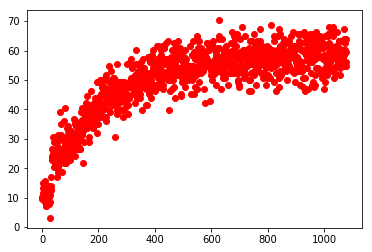

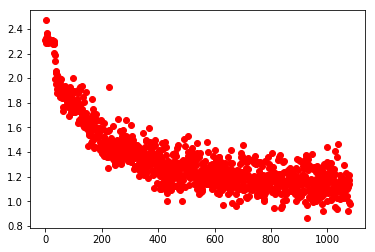

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

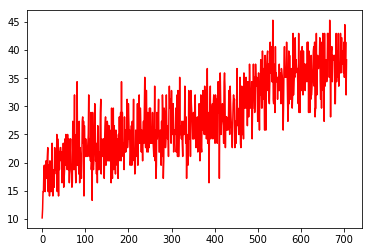

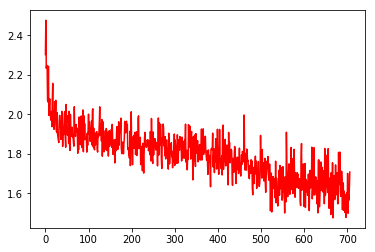

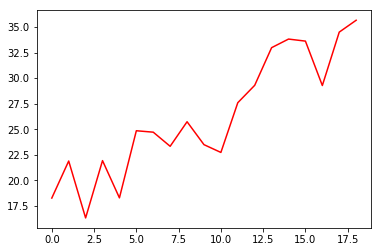

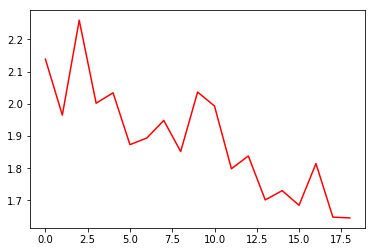

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()